# Bending energy loss and how it scales

MONAI's bending energy implementation seems to not be scale invariant.
This is making it difficult to tune the regularization weight after changing image scale.


## Analysis

Let's suppose we have a displacement vector field $u(x)$ which represents a deformation.
To make it easy, let's assume this is in 1D for now, so $u$ and $x$ are in $\mathbb{R}$.
We're working with images here, so there's an image domain $D\subseteq\mathbb{R}$ which is discretely sampled,
and $u:D\to\mathbb{R}$.

Suppose we want to work with a different image scale, say with $\lambda$ times as many pixels/voxels.
Imagine that images themselves are the "same", and just the resolution is different.

So we rescale the displacement vector field $u(x)$ to the new resolution,
obtaining $\hat{u}:\hat{D}\to\mathbb{R}$,
where $\hat{D}$ is the image of $D$ under $x\to\lambda x$.
We could refer to the function as $\hat{u}(\hat{x})$, where 
$$\hat{x}=\lambda x$$
and 
$$\hat{u}(\hat{x}) = \lambda u (x) = \lambda u (\lambda^{-1} \hat{x}).\tag{1}$$
This is only approximately true, because $\lambda^{-1}\hat{x}$ need not be in $D$, which we might imagine to be a discretely sampled rectangle. Let's assume the sampling is fine enough that, or $\lambda$ is chosen such that, this works.

Now recall that the bending energy loss based on $u$ would be
$$
L(u) = \frac{1}{|D|}\sum_{x\in D} \Vert H(u)(x) \Vert_F^2
$$
where $H(u)$ is the Hessian and $\Vert\cdot\Vert_F$ is the frobenius norm.

How does $L(\hat{u})$ relate to $L(u)$? One hopes that they'd be roughly equal,
so that bending energy loss is not sensitive to image scale. Let's compute.

Note that $\frac{d}{d\hat{x}} = \frac{dx}{d\hat{x}}\frac{d}{dx} = \lambda^{-1}\frac{d}{dx}$.
So it's easy to derive that
$$
\frac{d^2\hat{u}}{d\hat{x}^2} (\hat{x}) = \lambda^{-1} \frac{d^2u}{dx^2}(\lambda^{-1}\hat{x})
$$

Let's use $\hat{H}$ to denote the Hessian taken wrt $\hat{x}$ as the spatial variable.

Then $\Vert \hat{H}(\hat{u})(\hat{x}) \Vert_F^2 = \lambda^{-2}\Vert H(u)(\lambda^{-1}\hat{x})\Vert_F^2$. So
$$
L(\hat{u})
=  \frac{1}{|\hat{D}|}\sum_{\hat{x}\in \hat{D}}  \Vert \hat{H}(\hat{u})(\hat{x}) \Vert_F^2 \\
=   \frac{1}{\lambda |D|}\sum_{\hat{x}\in \hat{D}}  \Vert \hat{H}(\hat{u})(\hat{x}) \Vert_F^2\\
=   \frac{1}{\lambda |D|}\sum_{\hat{x}\in \hat{D}}  \lambda^{-2}\Vert H(u)(\lambda^{-1}\hat{x})\Vert_F^2\\
=   \frac{1}{\lambda |D|}\lambda \sum_{x\in D}  \lambda^{-2}\Vert H(u)(x)\Vert_F^2\\
=   \lambda^{-2} L(u).
$$

So bending energy loss is not scale invariant:
$$L(\hat{u}) = \lambda^{-2} L(u).$$
Working with an image that is downscaled by a factor of 2 will lead to a bending energy that is upscaled by a factor of 4. 

This calculation was simplified by the assumption that we are in 1D, however the result is the same in higher dimensions, if the scale factor is the same along each dimension.
This reasoning is:
- We have $\frac{d}{d\hat{x}_i} = \frac{dx_i}{d\hat{x}_i}\frac{d}{dx_i} = \lambda^{-1}\frac{d}{dx_i}$ as we got above for $x$, for each spatial dimension $i$.
- We get $\Vert \hat{H}(\hat{u}_i)(\hat{x}) \Vert_F^2 = \lambda^{-2}\Vert H(u_i)(\lambda^{-1}\hat{x})\Vert_F^2$ in each spatial direction.
- We have $L(u) = \frac{1}{|D|}\sum_{x\in D} \sum_i \Vert H(u_i)(x) \Vert_F^2$. The only difference from the above is the sum over spatial dimensions $i$, and the calculation above proceeds with very little change to give $L(\hat{u}) = \lambda^{-2} L(u)$.

## Demo

Below we demonstrate the scaling effect in 2D.

In [11]:
from monai import __version__
print(__version__)

0.9.dev2149


In [1]:
from monai.losses.deform import BendingEnergyLoss
import torch
from utils import plot_2D_vector_field, jacobian_determinant
import math
import matplotlib.pyplot as plt
import numpy as np

In [2]:
bending_loss = BendingEnergyLoss()

In [3]:
def get_example_loss_at_scale(s):
    ddf = torch.tensor(
        [[
            [(s/32)*math.sin(2*math.pi*(y/s) * 5),(s/32)*2*math.cos(2*math.pi* (x/s) * 3)]
            for x in range(s)]
            for y in range(s)
        ]
    ).permute((2,0,1))
    L = bending_loss(ddf.unsqueeze(0))
    if (s<80):
        plot_2D_vector_field(ddf, 1)
        plt.show()
        print(f"Bending loss at scale {s}: {L}")
    return L.item()

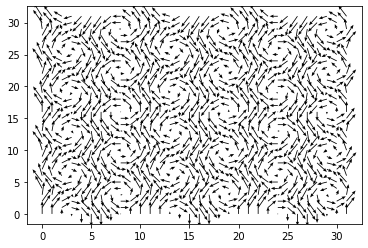

Bending loss at scale 32: 0.20914128422737122


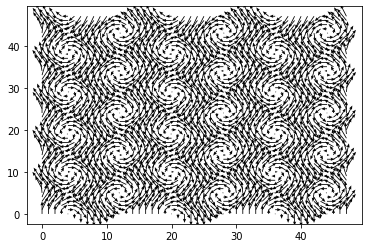

Bending loss at scale 48: 0.12400350719690323


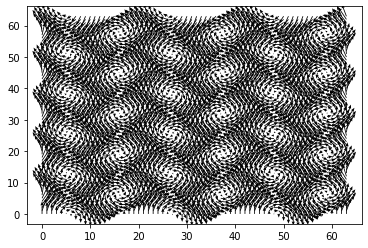

Bending loss at scale 64: 0.07776273041963577


In [4]:
loss_by_scale = [(s,get_example_loss_at_scale(s)) for s in range(32, 1024,16)]

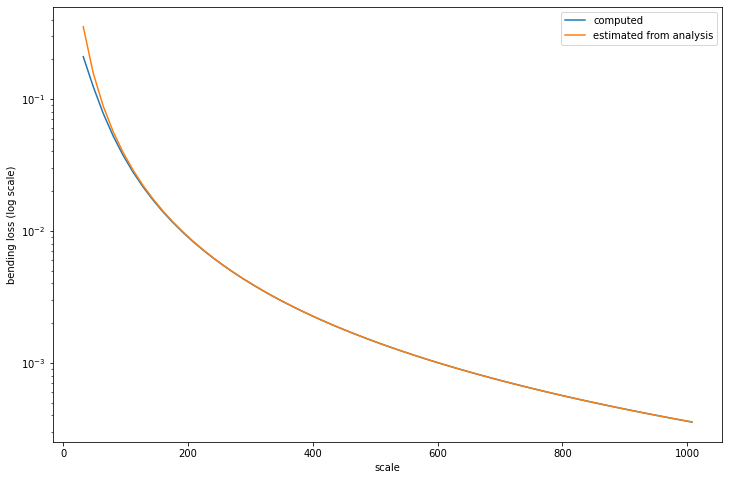

In [12]:
%matplotlib inline
loss_by_scale = np.array(loss_by_scale)
scales = loss_by_scale[:,0]
s0,l0 = loss_by_scale[-1]
plt.figure(figsize=(12,8))
plt.plot(scales,loss_by_scale[:,1], label='computed')
plt.plot(scales, [(s0/s)**2*l0 for s in scales], label='estimated from analysis')
plt.xlabel('scale')
plt.ylabel('bending loss (log scale)')
plt.yscale('log')
plt.legend()
plt.show()

Note that at lower resolutions the computed result disagrees a little with the analysis-- this is because the analysis makes the assumption (1) above, which fails at low resolutions.